# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [ ]:
# ! ln -s /path/to/your/imagenet/folder/ imagenet 

In [1]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
    
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0


## Loading Data and Model

In [2]:
imagenet_dir = '/home/siemens_diai/izzy/ImageNet'

dev = torch.device('cuda:0')

# select a model to analyse
# model = torchvision.models.vgg16(pretrained=True)
model = torchvision.models.resnet50(pretrained=True)
# model = torchvision.models.inception_v3(pretrained=True)
model.to(dev).eval()

# load the data
if type(model) == torchvision.models.inception.Inception3:
    image_size = 299
else:
    image_size = 224
    
# valset = ImageFolder(
#     os.path.join(imagenet_dir, 'train'),
#     transform=Compose([
#         CenterCrop(256), Resize(image_size), ToTensor(), 
#         Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ]))

trainset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

with open('imagenet_class_index.json') as f:
    idx2class = {int(k): v[1] for k, v in json.load(f).items()}

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
# img, target = valset[0]

### Insert the bottleneck into the model

You can experiment with the location of the bottleneck.

In [3]:
if type(model) == torchvision.models.vgg.VGG:
    iba = IBA(model.features[17])
elif type(model) == torchvision.models.resnet.ResNet:
    iba = IBA(model.layer2)
elif type(model) == torchvision.models.inception.Inception3:
    iba = IBA(model.Mixed_5b)

In [4]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [5]:
iba.estimate(model, trainloader, device=dev, n_samples=10000, progbar=True)

# Test the influence of different optimization steps (iterations)

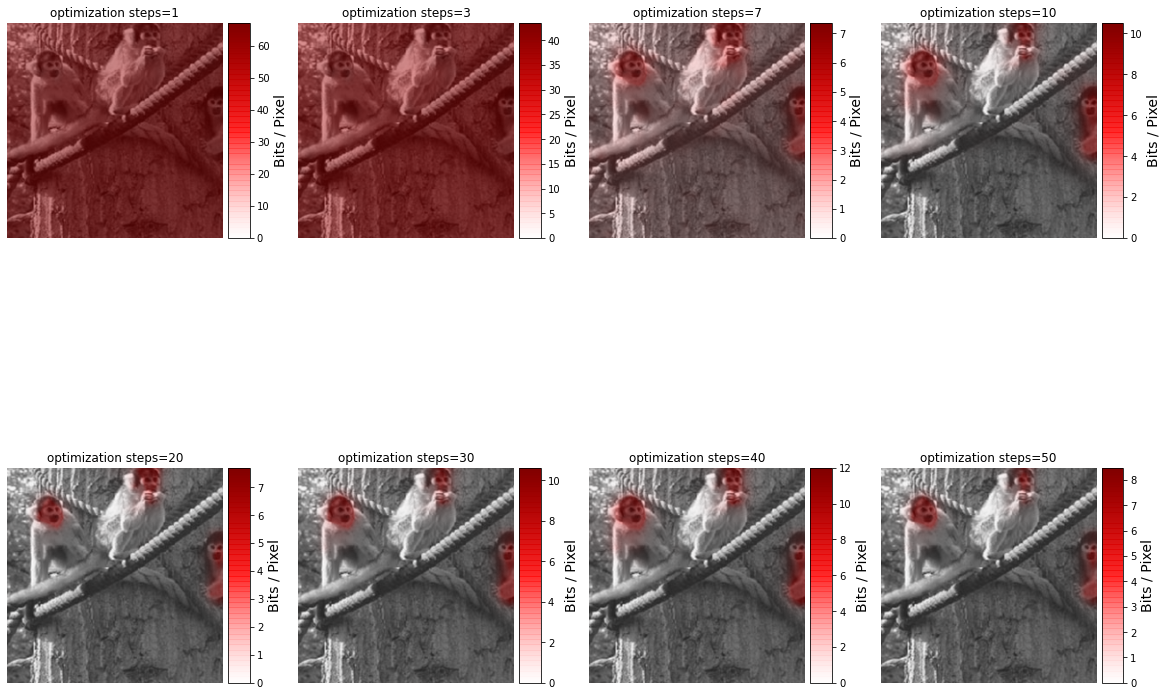

In [8]:
img = np.array(Image.open("./monkeys.jpg"))
img = (img.transpose(2, 0, 1) / 255)
target = 382  # 382: squirrel monkey

# preprocess image
img  = Compose([
    Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open("./monkeys.jpg"))

model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()


fig, axes = plt.subplots(2, 4, figsize=(20,15))

iter_set = [1, 3, 7, 10, 20, 30, 40, 50]
for iter_value, ax in zip(iter_set, axes.flatten()) : 
    heatmap = iba.analyze(img[None].to(dev), model_loss_closure, optimization_steps = iter_value) 
    ax = plot_saliency_map(heatmap, tensor_to_np_img(img), ax=ax)
    ax.set_title("optimization steps={}".format(iter_value))
plt.show()




